In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
c57_UMIs = pd.read_pickle('data/SS3_c57_UMIs_concat_ML.pkl')
c57_rpkms = pd.read_pickle('data/SS3_c57_rpkms_concat_ML.pkl')

In [4]:
c57_UMIs = c57_UMIs[c57_UMIs[1]][0]
c57_rpkms = c57_rpkms[c57_rpkms[1]][0]

In [5]:
c57_rpkms = c57_rpkms[~c57_rpkms.index.duplicated(keep='first')]
c57_UMIs = c57_UMIs[~c57_UMIs.index.duplicated(keep='first')]

In [6]:
c57_df = pd.DataFrame([c57_UMIs, c57_rpkms], index=['UMI','rpkm']).T.dropna(how='any')

In [7]:
c57_bf_UMI = pd.Series([gene[0] for gene in c57_df['UMI']], index=c57_df.index)
c57_bf_rpkm = pd.Series([gene[0] for gene in c57_df['rpkm']], index=c57_df.index)

In [8]:
cast_UMIs = cast_UMIs[cast_UMIs[1]][0]
cast_rpkms = cast_rpkms[cast_rpkms[1]][0]
cast_rpkms = cast_rpkms[~cast_rpkms.index.duplicated(keep='first')]
cast_UMIs = cast_UMIs[~cast_UMIs.index.duplicated(keep='first')]
cast_df = pd.DataFrame([cast_UMIs, cast_rpkms], index=['UMI','rpkm']).T.dropna(how='any')
cast_bf_UMI = pd.Series([gene[0] for gene in cast_df['UMI']], index=cast_df.index)
cast_bf_rpkm = pd.Series([gene[0] for gene in cast_df['rpkm']], index=cast_df.index)

SpearmanrResult(correlation=0.9330578992330714, pvalue=0.0)


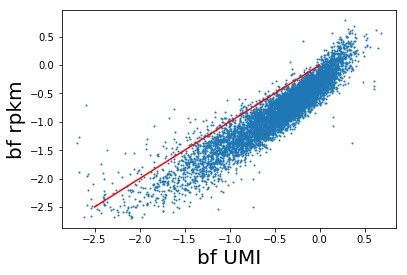

In [15]:
plt.scatter(np.log10(c57_bf_UMI), np.log10(c57_bf_rpkm), s=1)
print(spearmanr(np.log10(c57_bf_UMI), np.log10(c57_bf_rpkm)))
plt.plot([-2.5,0],[-2.5,0], color='red')
plt.xlabel('bf UMI', fontsize=20)
plt.ylabel('bf rpkm', fontsize=20)
plt.savefig('figures/ExtDataFig1e.pdf')
plt.show()

In [17]:
c57_bs_UMI = pd.Series([gene[2]/gene[1] for gene in c57_df['UMI']], index=c57_df.index)
c57_bs_rpkm = pd.Series([gene[2]/gene[1] for gene in c57_df['rpkm']], index=c57_df.index)

SpearmanrResult(correlation=0.4498724256326824, pvalue=0.0)


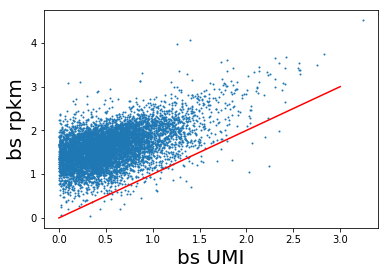

In [40]:
plt.scatter(np.log10(c57_bs_UMI), np.log10(c57_bs_rpkm), s=1)
print(spearmanr(np.log10(c57_bs_UMI), np.log10(c57_bs_rpkm)))
plt.plot([0,3],[0,3], color='red')
plt.xlabel('bs UMI', fontsize=20)
plt.ylabel('bs rpkm', fontsize=20)
plt.savefig('figures/ExtDataFig1f.pdf')
plt.show()

In [30]:
def MaximumLikelihood(vals, export_asymp_ci = False, fix = 0):
    from inference.moment_inference import MomentInference
    from scipy.interpolate import interp1d
    from scipy.optimize import minimize
    from scipy import special
    from scipy.stats import poisson,norm
    from scipy.special import j_roots
    from scipy.special import beta as beta_fun    
    import numpy as np
    if len(vals) == 0:
        return np.nan
    def dBP(at, alpha, bet, lam):
        at.shape = (len(at), 1)
        np.repeat(at, 40, axis = 1)
        def fun(at, m):
            if(max(m) < 1e6):
                return(poisson.pmf(at,m))
            else:
                return(norm.pdf(at,loc=m,scale=sqrt(m)))
        
        x,w = j_roots(40,alpha = bet - 1, beta = alpha - 1)
        gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
        prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
        return(prob)
    def LogLikelihood(x, vals):
        kon = x[0]
        koff = x[1]
        ksyn = x[2]
        return(-np.sum(np.log( dBP(vals,kon,koff,ksyn) + 1e-10))/len(vals))
    x0 = MomentInference(vals)
    if np.isnan(x0).any():
        x0 = np.array([10,10,10])
    bnds = ((1e-3,1e3),(1e-3,1e3), (1, 1e10))
    vals_ = np.copy(vals) # Otherwise the structure is violated.
    try:
        ll = minimize(LogLikelihood, x0, args = (vals_), method='L-BFGS-B', bounds = bnds)
    except:
        return np.nan
    #se = ll.hess_inv.todense().diagonal()
    estim = ll.x
    return ll.fun

In [25]:
def removeNAs(row):
    arr = row[1:len(row)]
    arr = arr[pd.notnull(arr)]
    return(arr.astype(int))

In [26]:
SS3_c57_rpkms = pd.read_csv('data/SS3_c57_rpkms_concat.csv', index_col=0)
SS3_c57_UMIs = pd.read_csv('data/SS3_c57_UMIs_concat.csv', index_col=0)

In [27]:
SS3_c57_rpkms = SS3_c57_rpkms.loc[~SS3_c57_rpkms.index.duplicated(keep='first')]

In [28]:
SS3_c57_UMIs = SS3_c57_UMIs.loc[~SS3_c57_UMIs.index.duplicated(keep='first')]

In [34]:
from joblib import delayed,Parallel

In [35]:
SS3_c57_ll = Parallel(n_jobs=50, verbose = 3)(delayed(MaximumLikelihood)(np.around(SS3_c57_rpkms.loc[gene][pd.notnull(SS3_c57_rpkms.loc[gene])])) for gene in c57_df.index.values)

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:1302: RuntimeWarning: invalid value encountered in double_scalars
  mu0 = np.sqrt(np.pi) * cephes.gamma(alpha + 0.5) / cephes.gamma(alpha + 1)
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:    0.5s
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:1302: RuntimeWarning: invalid value encountered in double_scalars
  mu0 = np.sqrt(np.pi) * cephes.gamma(alpha + 0.5) / cephes.gamma(alpha + 1)
[Parallel(n_jobs=50)]: Done 188 tasks      | elapsed:    1.6s
[Parallel(n_jobs=50)]: Done 412 tasks      | elapsed:    3.2s
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:266: RuntimeWarning: overflow encountered in double_scalars
  mu0 = 2.0**(alpha+beta+1)*cephes.beta(alpha+1, beta+1)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages

In [36]:
SS3_c57_ll_UMIs = Parallel(n_jobs=50, verbose = 3)(delayed(MaximumLikelihood)(np.around(SS3_c57_UMIs.loc[gene][pd.notnull(SS3_c57_UMIs.loc[gene])])) for gene in c57_df.index.values)

[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=50)]: Done 276 tasks      | elapsed:    2.9s
[Parallel(n_jobs=50)]: Done 724 tasks      | elapsed:    6.7s
[Parallel(n_jobs=50)]: Done 1061 tasks      | elapsed:    9.4s
[Parallel(n_jobs=50)]: Done 1413 tasks      | elapsed:   12.4s
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:266: RuntimeWarning: overflow encountered in double_scalars
  mu0 = 2.0**(alpha+beta+1)*cephes.beta(alpha+1, beta+1)
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:266: RuntimeWarning: invalid value encountered in double_scalars
  mu0 = 2.0**(alpha+beta+1)*cephes.beta(alpha+1, beta+1)
/mnt/k

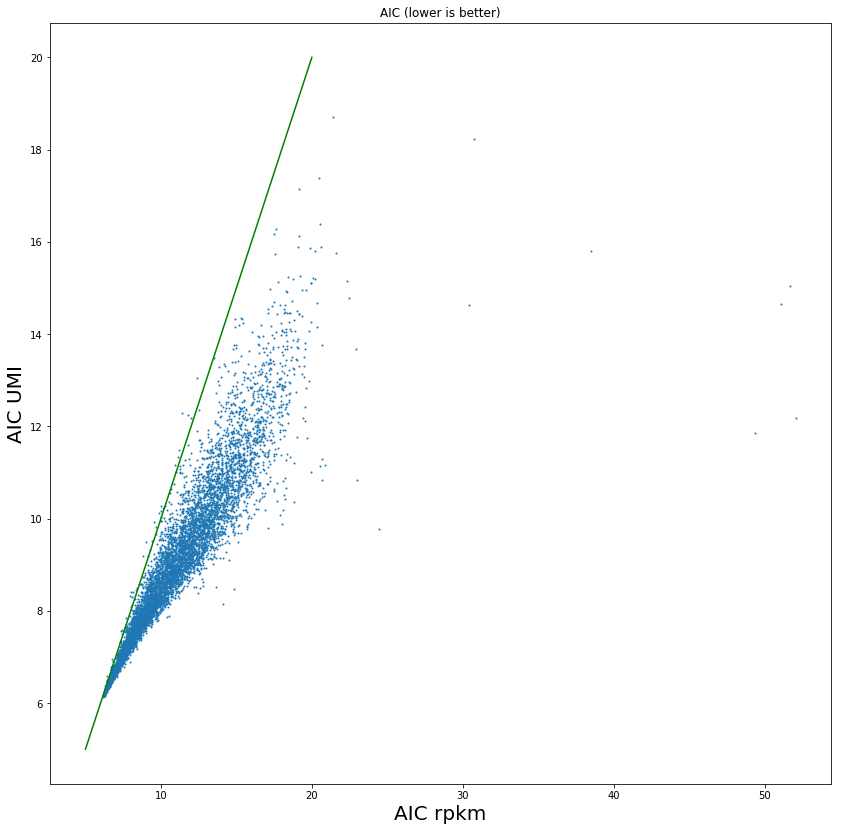

In [41]:
plt.figure(figsize=(14,14))
plt.scatter(6 + 2*np.asarray(SS3_c57_ll), 6 + 2*np.asarray(SS3_c57_ll_UMIs), s=1)
plt.title('AIC (lower is better)')
plt.xlabel('AIC rpkm', fontsize=20)
plt.ylabel('AIC UMI', fontsize=20)
plt.plot([5,20],[5,20],color='green')
plt.savefig('figures/ExtDataFig1d.pdf')
plt.show()